In [12]:
import torch
import torch.nn as nn
from torchvision.transforms.functional import rotate, InterpolationMode
import os
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#####################
# helper function
#####################
def plot_2_img_tensor(image1, image2, title1, title2):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(image1, cmap='gray')
    axs[0].set_title(title1)
    axs[1].imshow(image2, cmap='gray')
    axs[1].set_title(title2)
    plt.show()

In [48]:
#####################
# Import data
#####################

# Specify the file paths
sinogram_path = os.path.join(os.pardir, 'dataset_foam', 'x_train_sinograms.npy')
obj_path = os.path.join(os.pardir,'dataset_foam', 'foam_training.npy')

# Load the .npy files
sinogram_data = np.load(sinogram_path)
obj_data = np.load(obj_path)

# Convert the data to PyTorch tensors
sinogram_tensor = torch.from_numpy(sinogram_data)
obj_tensor = torch.from_numpy(obj_data)

# Check the tensor shapes
print("sinogram shape: ", sinogram_tensor.shape)
print("obj shape: ", obj_tensor.shape)
print("obj dtype: ", obj_tensor.dtype)

# Preprocess
image_batch = obj_tensor.unsqueeze(1) # Size = (n,y,x)
angles = np.arange(91, 271, dtype=float) # Angle list

sinogram shape:  torch.Size([50, 180, 184])
obj shape:  torch.Size([50, 128, 128])
obj dtype:  torch.float64


In [55]:
class ImageRotator(nn.Module):
    def __init__(self):
        super(ImageRotator, self).__init__()
        
    def forward(self, image_batch, angles):
        # Check input shapes
        assert len(image_batch.shape) == 4, "Invalid image_batch shape. Expected (n, c, y, x)."
        assert len(angles.shape) == 1, "Invalid angles shape. Expected (k,)."

        n, c, y, x = image_batch.shape
        k = angles.shape[0]
        
        # Initialize a tensor to store the rotated images
        rotated_imgs = torch.zeros((n, k, y, x), device=image_batch.device)

        for i in range(n):
            image = image_batch[i]  # Get current image
            for j in range(k):
                image_rotated = rotate(image, -angles[j], interpolation=InterpolationMode.BILINEAR)  # Rotate the image in the opposite direction
                rotated_imgs[i][j] = image_rotated
        self.rotated_batch = rotated_imgs

class ImgToSinogram(nn.Module):
    def __init__(self):
        super(ImgToSinogram, self).__init__()

    def forward(self, image_batch):
        # Check input shape
        assert len(image_batch.shape) == 4, "Invalid image_batch shape. Expected (n, k, y, x)."

        n, k, y, x = image_batch.shape

        # Initialize a tensor to store the sinograms
        sinograms = torch.zeros((n, k, x), device=image_batch.device)

        for i in range(n):
            sinogram = torch.zeros((k, x), device=image_batch.device)
            for j in range(k):
                image = image_batch[i, j]  # Get current image
                line_integrated = torch.sum(image, dim=1)  # Line integration along the y-axis
                sinogram[j, :] = line_integrated
            sinograms[i] = sinogram

        self.sinogram_batch = sinograms

In [56]:
start_time = time.time()

# Create an instances for the class
rotata = ImageRotator()
sinooo = ImgToSinogram()

# Pass the image batch and angles through the model
rotata.forward(image_batch, angles)
sinooo.forward(rotata.rotated_batch)

rotated_images_batch = rotata.rotated_batch
sinogram_batch = sinooo.sinogram_batch

print(rotated_images_batch.shape)
print(sinogram_batch.shape)

elapsed_time = time.time() - start_time
print("Took ",elapsed_time," sec")

torch.Size([50, 180, 128, 128])
torch.Size([50, 180, 128])
Took  6.696347951889038  sec


torch.Size([128, 128])
torch.Size([128, 128])
torch.Size([180, 128])


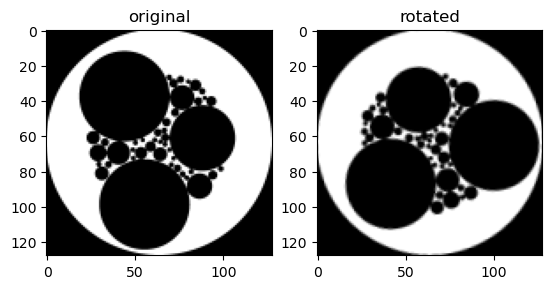

In [57]:
a = image_batch[0].squeeze()
b = rotated_images_batch[0][169]
c = sinogram_batch[0]

print(a.shape)
print(b.shape)
print(c.shape)

# plot_2_img_tensor(a,c,"original","sinogram")
plot_2_img_tensor(a,b,"original","rotated")

In [66]:
# Specify the file path
sinogram_orininal_path = os.path.join(os.pardir, 'dataset_foam', 'x_train_sinograms.npy')
sinogram_original = np.load(sinogram_orininal_path)

obj = image_batch[:5]
my_sinogram = sinogram_batch[:5]
target_sinogram = sinogram_original[:5]

print(target_sinogram[0].shape)
print(sinogram_batch[0].shape)

(180, 184)
torch.Size([180, 128])


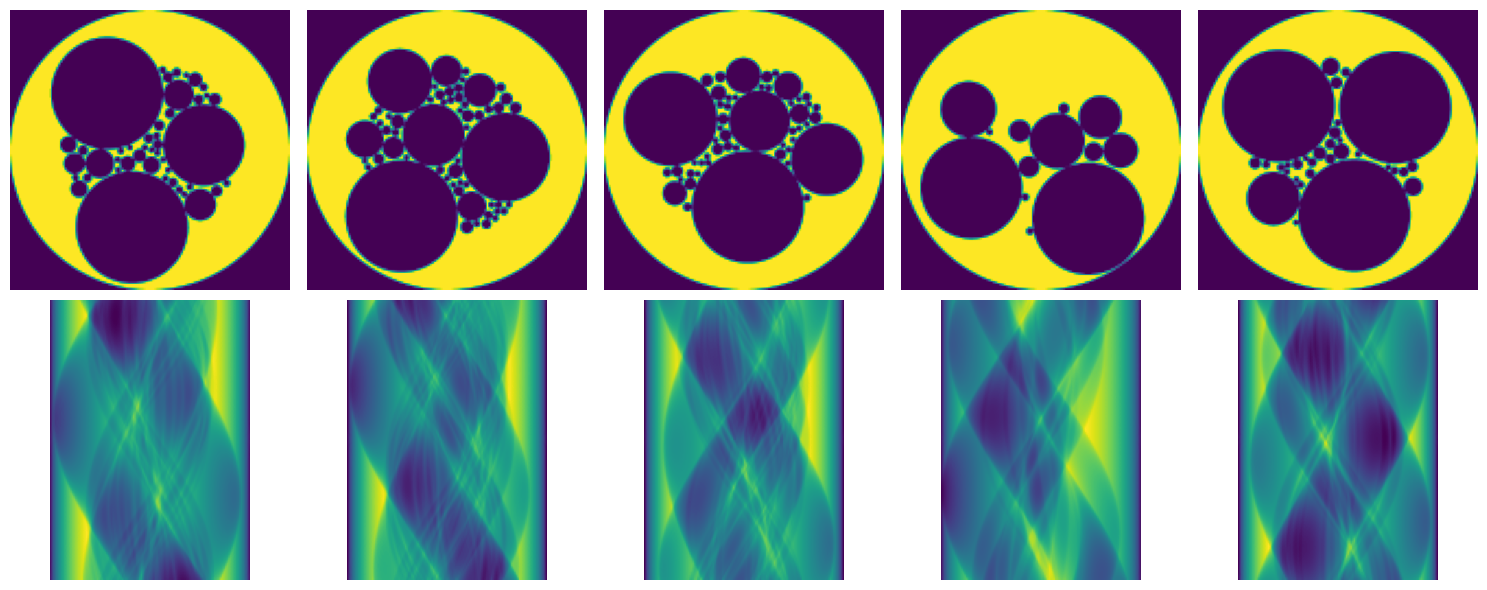

In [59]:
# Plot the images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, obj in enumerate(obj):
    axes[0, i].imshow(obj.squeeze())
    axes[0, i].axis('off')

for i, sino in enumerate(my_sinogram):
    axes[1, i].imshow(sino)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

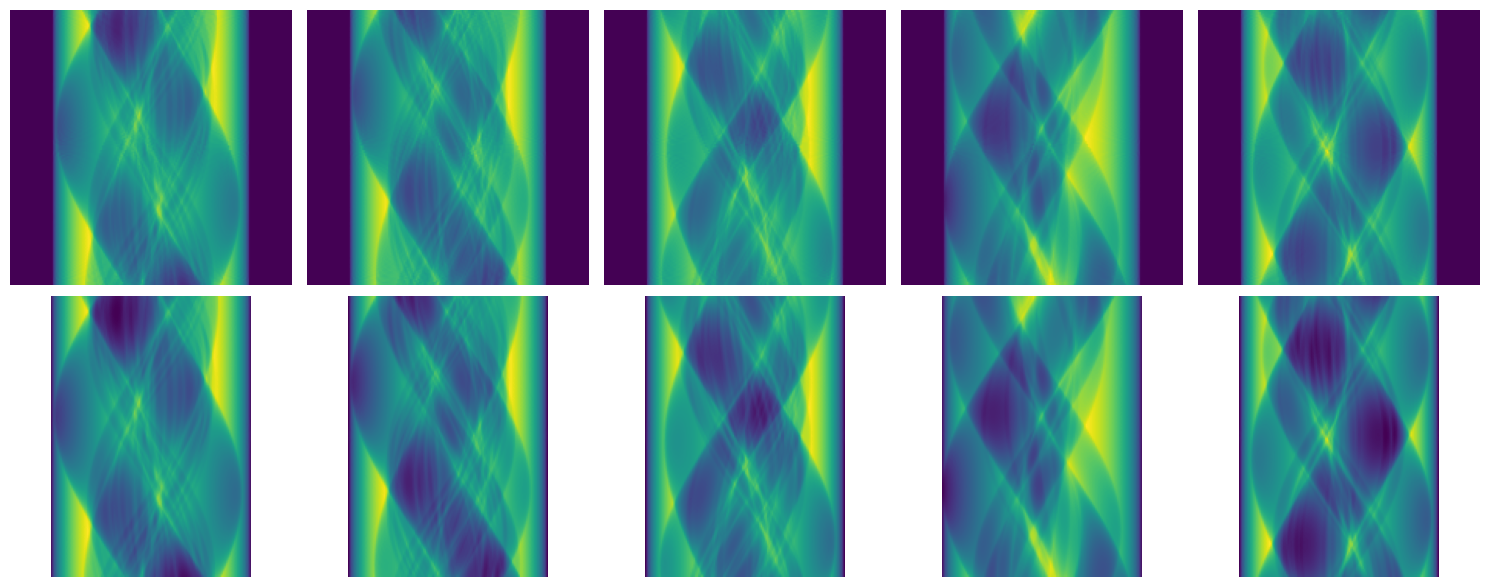

In [60]:
# Plot the images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, target in enumerate(target_sinogram):
    axes[0, i].imshow(target.squeeze())
    axes[0, i].axis('off')

for i, sino in enumerate(my_sinogram):
    axes[1, i].imshow(sino)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()